In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import visuals as vs
from time import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, LinearSVC

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
df = pd.read_csv("./census.csv")

# Feature engineering as per EDA
df['capital-diff'] = df['capital-gain'] - df['capital-loss'] 
df['native-binary'] = df['native-country'].map(lambda x: 1 if x == 'United-States' else 0)

# Split the data into features and target label
features_raw = df.drop(['income','capital-gain','capital-loss','education_level','native-country'], axis = 1)
income_raw = df['income']

# One-hot encode catagorical features using pandas.get_dummies()
features_final = pd.get_dummies(features_raw)

# Remove redundant feature names after one-hot encoding
features_final.columns = features_final.columns.str.replace('marital-status_ ', '')

# Encode the 'income_raw' feature to numerical values, only keep '>50K' category
income = pd.get_dummies(income_raw, drop_first = True)

# Print the number of features after one-hot encoding
features_raw_l = list(features_raw.columns)
print("There're {} total features before one-hot encoding.".format(len(features_raw_l)))
    
# Print the number of features after one-hot encoding
features_final_l = list(features_final.columns)
print("There're {} total features after one-hot encoding.".format(len(features_final_l)))

There're 11 total features before one-hot encoding.
There're 46 total features after one-hot encoding.


In [2]:
# Apply feature scaling
features_final[features_final_l] = MinMaxScaler() \
                                    .fit_transform(features_final[features_final_l])

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

C:\Users\Junjie\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training set has 36177 samples.
Testing set has 9045 samples.


In [3]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner.fit(X_train, y_train.values.ravel())
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set
    start = time() # Get start time
    p_test = learner.predict(X_test)
    p_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    # Compute accuracy on the train set
    results['acc_train'] = accuracy_score(y_train, p_train)
        
    # Compute accuracy on the test set
    results['acc_test'] = accuracy_score(y_test, p_test)
    
    # Compute F-score on the train set
    results['f_train'] = fbeta_score(y_train, p_train, beta=1)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, p_test, beta=1)
       
    # Success
    print("{} is trained.".format(learner.__class__.__name__))
        
    # Return the results
    return results

C:\Users\Junjie\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC is trained.


C:\Users\Junjie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier is trained.
GradientBoostingClassifier is trained.


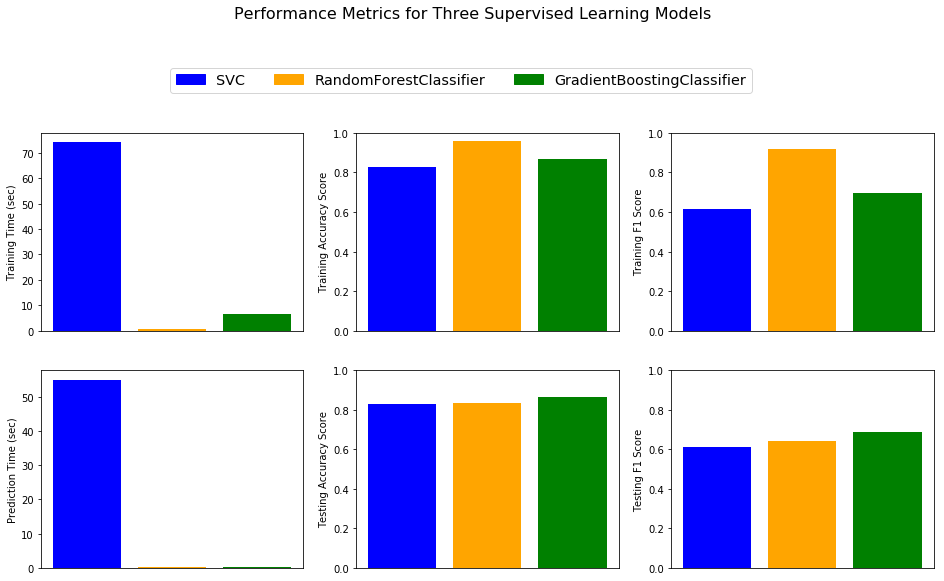

In [4]:
# Initialize the three models
clf_A = SVC(random_state=0)
clf_B = RandomForestClassifier(random_state=0)
clf_C = GradientBoostingClassifier(random_state=0)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.model_evaluate(results)

Unoptimized model
------
Accuracy score on testing data: 0.8640
Precision score on testing data: 0.7849
Recall score on testing data: 0.6091
F-score on testing data: 0.6859

Optimized Model
------
Accuracy score on the testing data: 0.8714
Precision score on testing data: 0.7853
Recall score on testing data: 0.6503
F-score on the testing data: 0.7115


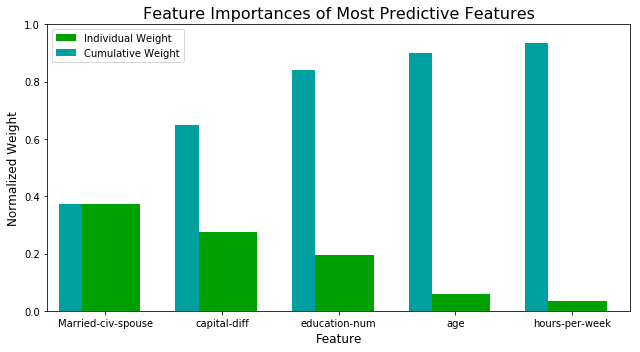

In [5]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)

# Create the parameters list you wish to tune, using a dictionary if needed.
param_grid = {'n_estimators':[100, 200, 400]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid, scoring=scorer, cv=kfold)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using unoptimized model
p_test_raw = (clf.fit(X_train, y_train.values.ravel())).predict(X_test)

# Make predictions using optimized model
p_test_opt = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, p_test_raw)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, p_test_raw)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, p_test_raw)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, p_test_raw, beta = 1)))

print("\nOptimized Model\n------")
print("Accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, p_test_opt)))
print("Precision score on testing data: {:.4f}".format(precision_score(y_test, p_test_opt)))
print("Recall score on testing data: {:.4f}".format(recall_score(y_test, p_test_opt)))
print("F-score on the testing data: {:.4f}".format(fbeta_score(y_test, p_test_opt, beta = 1)))

# Extract the feature importances from the best estimator
importances = best_clf.feature_importances_

# Plot
vs.feature_importance(importances, X_train, y_train)